# Impact Function Calibration

Here is a walkthrough of the NCCS calibration module.

The structure and naming mirrors the CLIMADA calibration module, but this addds flexibility and functionality to calibrate entire model pipelines and heterogeneous observations.


In [1]:
# Import
import sys
sys.path.append('../..')
import logging
import climada
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import copy
import os
import pycountry
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import mean_squared_log_error
from climada.util import log_level
from climada.entity import ImpactFuncSet, ImpfTropCyclone

from calibration.base import NCCSInput
from calibration.bayesian_optimizer import NCCSBayesianOptimizer, NCCSBayesianOptimizerController
from calibration.rp_errors import rp_rmse
from utils import folder_naming

logging.getLogger("climada").setLevel("INFO")
warnings.filterwarnings("ignore", category=DeprecationWarning)

LOGGER = logging.getLogger(__name__)

/usr/local/Caskroom/miniforge/base/envs/nccs_dev_jupyter/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


## User-supplied components of an NCCS calibration

The input to an NCCS calibration looks like this:

```
input = NCCSInput(
    config = config_template,
    data = obs,
    write_impact_functions = write_regional_tc_impact_function,
    return_period_impacts_from_config = return_period_impacts_from_config,
    cost_func = rp_rmse,
    bounds = bounds,
    constraints = constraints,
    linear_param='scale'
)
```

We'll go through these components one by one

### 1. Config template

A calibration will run the modelling pipeline many times, each time sampling from the parameter space we're exploring and optimising, each time giving different impact functions.

The `config_template` describes the model pipeline that will be run each time. The code will update the run's name each time the model is called so taht outputs are stored separately.

The impact functions themselves are _not_ contained in the config file. The `"calibrated": "custom"` entry says that impact functions should be read from a file, which the calibration will provide each time the model is called.

In [2]:
# NCCS model config

import pathos as pa
ncpus = 3
ncpus = pa.helpers.cpu_count() - 2

project_folder = "calibration_v1/TC/SI/"

config_template = {
    "run_title": project_folder + "TC_SI_",
    "n_sim_years": 0,                   # (We don't do this part of the pipeline)
    "io_approach": [],                  # (We don't do this part of the pipeline)
    "force_recalculation": False,
    "use_s3": False,
    "log_level": "WARNING",
    "seed": 161,

    # Which parts of the model chain to run:
    "do_direct": True,                  # Calculate direct impacts (that aren't already calculated)
    "do_yearsets": False,               # Calculate direct impact yearsets (that aren't already calculated)
    "do_multihazard": False,            # Also combine hazards to create multi-hazard supply chain shocks
    "do_indirect": False,               # Calculate any indirect supply chain impacts (that aren't already calculated)

    # Impact functions:
    "business_interruption": False,     # Turn off to assume % asset loss = % production loss. Mostly for debugging and reproducibility
    "calibrated": "custom",             # Custom impacts

    # Parallisation:
    "do_parallel": True,                # Parallelise some operations
    "ncpus": ncpus,

    "runs": [
        {
            "hazard": "tropical_cyclone",
            "io_approach": [],
            "sectors": ["economic_assets"],
            "countries": None,   # We'll set these in a moment
            "scenario_years": [
                {"scenario": "None", "ref_year": "historical"},
            ],
        },
    ]
}

## 2. Observation data

The observations are prepared by scripts in the resources/calibration_calculations/observations_calculations/ folder and stored in the resources/calibration_calculations/observations_calculations/ folder.

For TCs all observations are currently of the form region - country - event_id - return period - impact (USD), extracted from EM-DAT.

The calibration of the impact functions will compare modelled return period losses to the these observations.

This calibration is for the Southern Indian ocean `SI` region because it's computationally quite cheap.

In [3]:
# Load observations

obs = pd.read_csv("../../resources/observations/data/tc.csv")
obs = obs[(obs["cal_region2"] == "SI")]

countries_iso3alpha = obs['country'].unique()
countries = [pycountry.countries.get(alpha_3=c).name for c in countries_iso3alpha]
n_years =max(obs['rp'])

# Set the run's countries to these
config_template['runs'][0]['countries'] = countries

obs

,country,cal_region2,event_id,impact,rp
202,MDG,SI,1984094S10080,9.077708e+08,38.000000
203,MDG,SI,1981351S12060,7.422745e+08,19.000000
204,MDG,SI,2004061S12072,6.114618e+08,12.666667
205,MDG,SI,1986067S11080,4.913706e+08,9.500000
206,MDG,SI,2007066S12066,3.488589e+08,7.600000
207,MDG,SI,1997018S11059,1.505103e+08,6.333333
208,MDG,SI,2012039S14075,1.075983e+08,5.428571
209,MDG,SI,1983339S10065,7.598812e+07,4.750000
210,MDG,SI,2008037S10055,6.803472e+07,4.222222
211,MDG,SI,1994007S16056,3.585277e+07,3.800000


# 3. `write_impact_functions`: a method to write custom impact functions from sampled input parameters

This is the model pipeline setup stage. Any changes to the model inputs and pipeline before it's run are made here, based on the sampled parameters for this run of the model. 

Currently this means writing impact functions defined by the input parameters to a file that is read in during the impact calculations.

In [4]:
from calibration.utils import write_sigmoid_impf_to_file

def write_regional_tc_impact_function(v_half, scale):
    write_sigmoid_impf_to_file('tropical_cyclone', v_half, scale)

## 4. `return_period_impacts_from_config`: a method to reproduce the observations with the model

This is the most complex part of the setup.

Given the observations that we have (and given that they might be very heterogeneous: a bunch of summary statistics gathered from the literature), we need a method that runs the NCCS modelling pipeline and then reads in the results to recreate the observations.

The output of this method will be used as input to the following `cost_func` cost function, which we also supply (so there is some flexibility).

The method below takes a config file (the optimizer takes the config template and generates a new config for each iteration). It runs the model pipeline and then reads the output, calculating return period losses by country to match the observations we have.

In [5]:
# We need this method in other places too: go check it out, it's at the core of the calibration
from calibration.utils import return_period_impacts_from_config

# OK fine I've copied it here for you to look at too (as of 26/09/24)
def _copy_of_return_period_impacts_from_config_dont_use(config):
    # Run the pipeline
    analysis_df = run_pipeline_from_config(config)

    # Load results to match the observations
    countries = config['runs'][0]['countries']
    imp_path_country = {country: list(analysis_df[analysis_df['country']==country]['direct_impact_path'])[0] for country in countries}
    imp_country = [
        pd.DataFrame({
            'country': pycountry.countries.get(name=country).alpha_3,
            'impact': Impact.from_hdf5(imp_path_country[country]).at_event
            })
        for country in countries
        ]
    
    for imp in imp_country:
        if not np.any([imp['impact']]):
            LOGGER.warning(f'No modelled impacts in country {imp["country"][0]}')

    df = pd.concat(imp_country)
    df = df.sort_values(['country', 'impact'], ascending=[True, False])
    df['rank'] = df.groupby(['country']).cumcount() + 1

    assert(len(config['runs'] == 1))
    n_years_sim = HAZ_N_YEARS[config['runs'][0]['hazard']]
    df['rp'] = df.groupby(['country'])['rank'].transform(lambda x: n_years / x) 
    df = df[['country', 'impact', 'rp']]
    df = df.reset_index()
    return df

## 5. The cost function

This is a method that takes two dataframes: the observations and the observations as reproduced by the model. It aligns them and calculates some measure of the 'difference' between them (a 0 is a perfect reproduction, and higher values mean the model is worse. Note this is different from optimizations that want to maximize the objective function: the code accounts for this).

In this case we use the root mean square error which is provided by a util function in `calibration.rp_errors`.

There are three decisions/assumptions worth noting in this choice of cost function:
- we use the root mean square error to evaluate model performance (not the log). This means that error from small events aren't very important and errors from large events dominate the cost function. This is what we want. (Other options to consider: root_mean_squared_log_error, mean_squared_error)
- all return periods are weighted equally. If we want to weight towards more extreme events we can reconsider this
- all events are weighted equally. That means that countries with more events (and therefore more observations) have a stronger effect on the calibration

In [6]:
cost_function = rp_rmse

## 6. The input parameter bounds

These provide a permitted range for each parameter we're working with. It's a dictionary giving bounds for each parameter.

In [7]:
# bounds = {"v_thresh": (25.8, 25.8), "v_half": (25.8, 150), "scale": (0.01, 1)}
bounds = {"v_half": (25.81, 150), "scale": (0.01, 1)}

Later we will also need code to visualise the input parameters. In this case the parameters correspond directly to a single impact function, though this won't always be the case.

In [8]:
from climada.entity import ImpfTropCyclone

def impf_from_params(params):
    return ImpfTropCyclone.from_emanuel_usa(v_thresh = 25.8, v_half=params['v_half'], scale=params['scale'], intensity=np.arange(0, 121, 1))

The 'default' impact function that we're improving on is this:

<Axes: title={'center': 'TC 5: South Indian (SI)'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

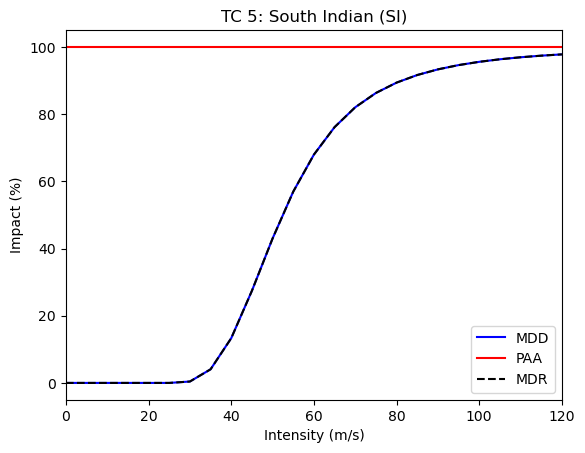

In [9]:
from pipeline.direct.direct import get_impf_tc
from climada.entity import ImpfSetTropCyclone

default_impf = ImpfSetTropCyclone.from_calibrated_regional_ImpfSet()
default_impf = default_impf.get_func(haz_type='TC', fun_id=5)  # 1: NA1, 5: SI
default_impf.plot()

And the parameter space we're searching is huge. We can sample it:

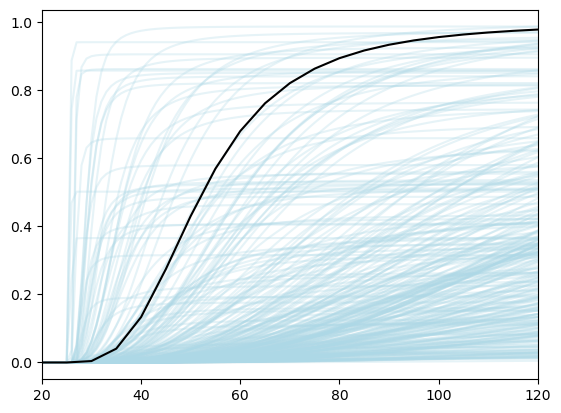

In [10]:
fig, ax = plt.subplots()

n_samples = 300
v_half_samples = np.random.uniform(*bounds['v_half'], size=n_samples)
scale_samples = np.random.uniform(*bounds['scale'], size=n_samples)

for i in range(n_samples):
    v_half = v_half_samples[i]
    scale = scale_samples[i]
    impf = impf_from_params({'v_half': v_half, 'scale': scale})
    ax.plot(
        np.arange(20,121),
        impf.calc_mdr(np.arange(20,121)),
        color='lightblue',
        alpha=0.3
    )

ax.plot(
    np.arange(1,121),
    default_impf.calc_mdr(np.arange(1,121)),
    color='black',
)

ax.set_xlim([20, 120])

plt.show()


# Constraints

The BayesianOptimization also takes `constraints`. These can also be provided here. There are no constraints in this run.

When we apply constraints later we'll do it in a strangely crude way where we code them ourselves and  return a really bad result that the cost function will hate. Seems like a weird approach but it's recommended here: https://bayesian-optimization.github.io/BayesianOptimization/1.5.1/constraints.html#1.-Simple-Constrained-Optimization

In [11]:
constraints = None

# Linear parameter

The `linear_param` parameter is new to the NCCS calibration.

If you know that the impacts in the data frame produced by the `return_period_impacts_from_config` method are linear in one of the input parameters, specify that here.

For most impact functions that we'll look at in NCCS there will be a `scale` parameter which provides a linear scaling to the impacts. So we specify this here.

The modelling pipeline is set up to recognise that adjustments to this parameter are extremely cheap and so it samples generously when this is the case.

# Run the calibration

Now we can put this all together!

In [8]:
from climada.util import log_level

logging.getLogger('calibration').setLevel(logging.DEBUG)


# Define calibration input
with log_level("WARNING", name_prefix="climada"):
    with log_level("INFO", name_prefix="climada.util.calibrate"):
        input = NCCSInput(
            config = config_template,
            data = obs,
            write_impact_functions = write_regional_tc_impact_function,
            return_period_impacts_from_config = return_period_impacts_from_config,
            cost_func = cost_function,
            bounds = bounds,
            constraints = constraints,
            linear_param='scale'
            # results_file='SI_results.csv'
        )

        # Create and run the optimizer
        opt = NCCSBayesianOptimizer(input)
        controller = NCCSBayesianOptimizerController.from_input(input)
        bayes_output = opt.run(controller)
        bayes_output.params  # The optimal parameters

2024-10-02 08:16:37,666 - calibration.base - DEBUG - Creating the NCCSInput object
2024-10-02 08:16:37,667 - calibration.bayesian_optimizer - DEBUG - Initialising the NCCSBayesianOptimizer
2024-10-02 08:16:37,668 - calibration.base - DEBUG - Initialising an NCCSOptimizer with a cache
2024-10-02 08:16:37,668 - calibration.bayesian_optimizer - DEBUG - Initialising the NCCSBayesianOptimization
2024-10-02 08:16:37,670 - calibration.bayesian_optimizer - DEBUG - Starting the execution of the NCCSBayesianOptimizer
2024-10-02 08:16:37,672 - calibration.bayesian_optimizer - INFO - Gathering any data saved from previous runs in /Users/chrisfairless/Projects/CelsiusPro/nccs-supply-chain/results/calibration_v1/TC/SI
2024-10-02 08:16:37,673 - calibration.bayesian_optimizer - DEBUG - Found a total of 0 existing outputs (full or partial)
2024-10-02 08:16:37,674 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 0
2024-10-02 08:16:37,675 - calibration.bayesian_optimizer - DEB

In [12]:
output_dir = Path(folder_naming.get_direct_output_dir(config_template['run_title'])).parent.parent
calibration_output_path = Path(output_dir, 'optimisation_output.hdf5')

In [ ]:
# Save output to file
bayes_output.to_hdf5(calibration_output_path)

In [9]:
# Upload the output to S3
from utils.s3client import upload_project_folder_to_s3
upload_project_folder_to_s3(project_folder)

In [13]:
# Read output from file
from calibration.bayesian_optimizer import NCCSBayesianOptimizerOutput
bayes_output = NCCSBayesianOptimizerOutput.from_hdf5(calibration_output_path)

## Evaluate Output

The Bayesian Optimizer returns the entire paramter space it sampled and we can investigate the cost function's behaviour within this space.

Here we print the samples examined by the optimizer. Notice that the optimal parameter set is not necessarily the last entry in the parameter space!

In [14]:
p_space_df = bayes_output.p_space_to_dataframe()
p_space_df

Parameters               Calibration
               scale      v_half Cost Function
Iteration                                     
0           0.422852  115.267099  3.441414e+08
1           0.083282  115.267099  3.463186e+08
2           0.209012  115.267099  3.455119e+08
3           0.299102  115.267099  3.449343e+08
4           0.359492  115.267099  3.445473e+08
...              ...         ...           ...
2756        0.171012   27.460170  7.790400e+08
2757        0.261102   27.460170  1.351972e+09
2758        0.386832   27.460170  2.155103e+09
2759        0.554142   27.460170  3.225381e+09
2760        0.768972   27.460170  4.600403e+09

[2761 rows x 3 columns]

In contrast, the controller only tracks the consecutive improvements of the best guess:

In [15]:
controller.improvements()

NameError: name 'controller' is not defined

Notice that the optimal parameter set is not necessarily the last entry in the parameter space!
Therefore, let's order the parameter space by the ascending cost function values.

In [16]:
p_space_df = p_space_df.sort_values(("Calibration", "Cost Function"), ascending=True)
p_space_df

Parameters              Calibration
               scale     v_half Cost Function
Iteration                                    
2260        0.050445  27.296465  1.201842e+08
2237        0.050114  27.311147  1.201957e+08
2739        0.050812  27.301013  1.202113e+08
2735        0.049822  27.301013  1.202406e+08
2234        0.051104  27.311147  1.202584e+08
...              ...        ...           ...
2246        0.772814  27.311147  4.662672e+09
2000        0.777960  27.369327  4.681840e+09
2334        0.886933  28.116979  5.078385e+09
1882        0.904990  28.125807  5.183767e+09
2001        0.903690  27.369327  5.490604e+09

[2761 rows x 3 columns]

We can then plot the cost function within the parameter space:

[<Axes: title={'center': 'Cost function within parameter space (log colour scale)'}, xlabel='(Parameters, scale)', ylabel='(Parameters, v_half)'>]

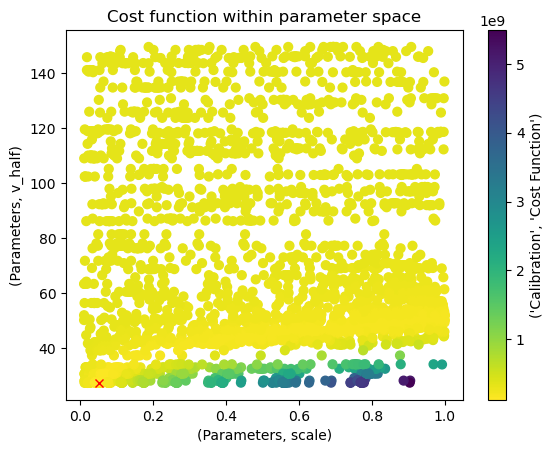

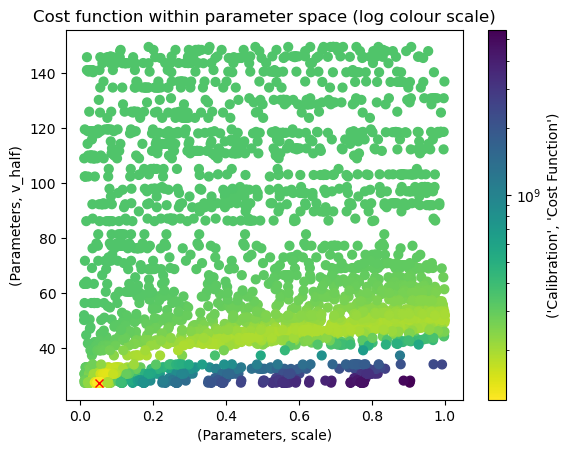

In [17]:
import matplotlib as mpl
bayes_output.plot_p_space(title = 'Cost function within parameter space')
bayes_output.plot_p_space(norm = mpl.colors.LogNorm(), title = 'Cost function within parameter space (log colour scale)')

And print the 'optimal' parameters

In [18]:
# optimal_params = p_space_df["Parameters"].iloc[0, :].to_dict()
optimal_params = bayes_output.get_optimal_params()
optimal_params

{'scale': 0.050444998424069055, 'v_half': 27.29646486678632}

## Analyze the Calibration

Let's see how the models perform.

### Fitted impact functions

We can look at the fitted impact functions

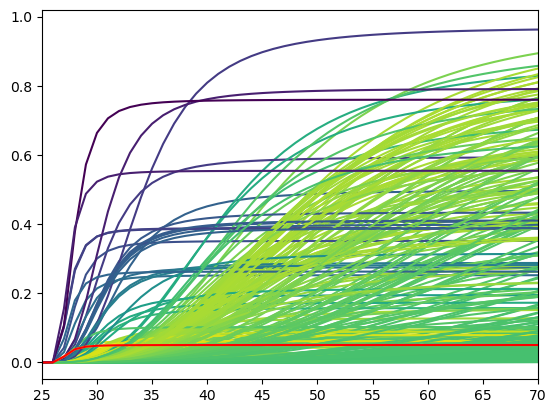

In [19]:
parameter_df = p_space_df['Parameters']
cost_df = p_space_df['Calibration']

n_samples = 300

n_iters = p_space_df.shape[0]
samples = np.random.randint(0, n_iters, size=n_samples)

param_samples = [parameter_df.iloc[i,] for i in samples]
cost_samples = [cost_df.iloc[i,]['Cost Function'] for i in samples]
norm = mpl.colors.LogNorm(vmin=min(cost_samples), vmax=max(cost_samples))
cmap = cm.get_cmap('viridis_r')

_, ax = plt.subplots()
for cost, params in zip(cost_samples, param_samples):
    impf = impf_from_params(params)
    ax.plot(
        np.arange(1,121),
        impf.calc_mdr(np.arange(1,121)),
        color = cmap(norm(cost)),
    )

best_impf = impf_from_params(optimal_params)
ax.plot(
    np.arange(1,121),
    best_impf.calc_mdr(np.arange(1,121)),
    color='red',
)

ax.set_xlim([25, 70])
plt.show()

### Exceedance curves

Next we'll compare modelled return periods curves.

To do this we'll get the optimal model output:

In [20]:
from utils import folder_naming
import hashlib

# TODO make a more user-friendly way to access these

def get_saved_results():
    output_dir = Path(folder_naming.get_direct_output_dir(config_template['run_title'])).parent.parent
    output_folders = os.listdir(output_dir)
    return [pd.read_csv(Path(output_dir, d, 'direct', 'reproduced_obs.csv')) for d in output_folders if d != 'optimisation_output.hdf5']
    

def get_results_from_params(params):
    run_title = config_template['run_title'] + NCCSBayesianOptimizer.hash_params(params)
    direct_output_dir = folder_naming.get_direct_output_dir(run_title)
    results_path = Path(direct_output_dir, 'reproduced_obs.csv')
    return pd.read_csv(results_path)

optimal_df = get_results_from_params(optimal_params)

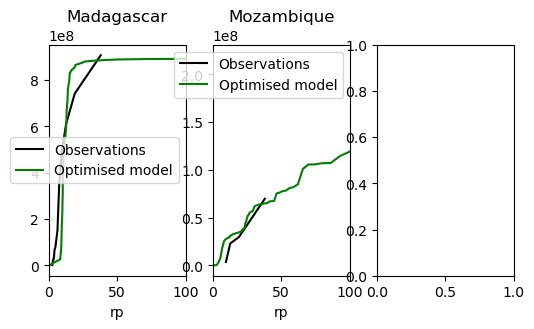

In [21]:
n_plot_rows = int(np.ceil(len(countries) / 3))
_, axs = plt.subplots(ncols=3, nrows=n_plot_rows, figsize=(6, 2*n_plot_rows+1))

for c, ax in zip(countries, axs):
    country = pycountry.countries.get(name=c).alpha_3
    obs[obs['country'] == country].plot(x='rp', y='impact', label='Observations', color='black', title=c, ax=ax)
    optimal_df[optimal_df['country'] == country].plot(x='rp', y='impact', label='Optimised model', color='green', ax=ax)
    ax.set_xlim([0, 100])
plt.show()

And we can look at the range of fits:

In [22]:
parameter_df = p_space_df['Parameters']
cost_df = p_space_df['Calibration']

saved_results = get_saved_results()

2024-10-02 17:34:32,725 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:34:33,186 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:34:33,520 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:34:33,930 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:34:34,270 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:34:34,587 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of o

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x110bb5690>>
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniforge/base/envs/nccs_dev_jupyter/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


2024-10-02 17:35:01,945 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:35:02,335 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:35:02,769 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:35:03,177 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:35:03,571 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:35:04,190 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of o

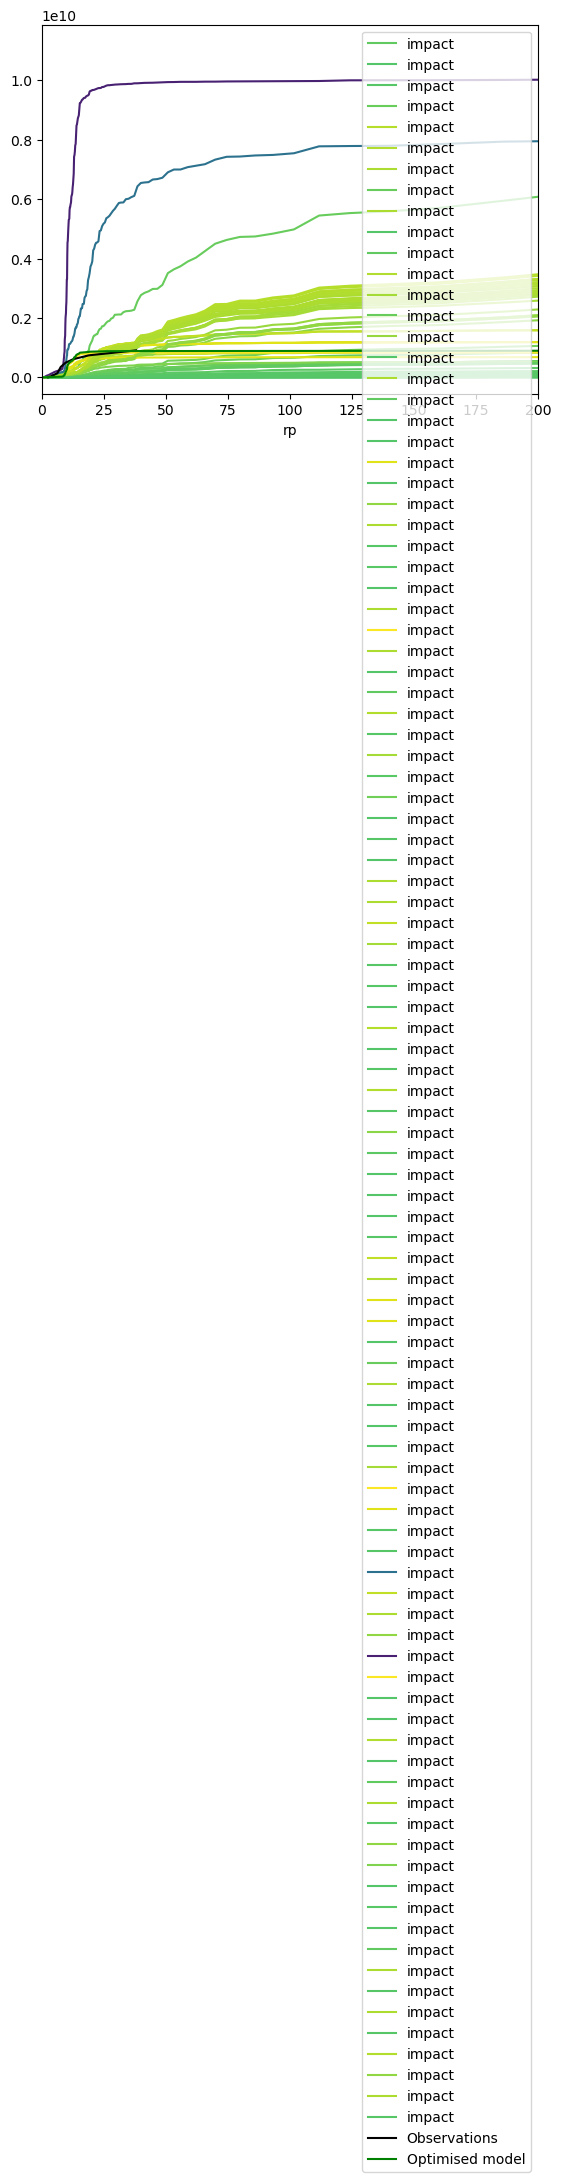

2024-10-02 17:35:36,065 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:35:36,381 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:35:36,693 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:35:36,995 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:35:37,289 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of observations for 2 countries: ['MDG', 'MOZ']
2024-10-02 17:35:37,580 - calibration.rp_errors - WARNING - In the cost calculation there were missing modelled reproductions of o

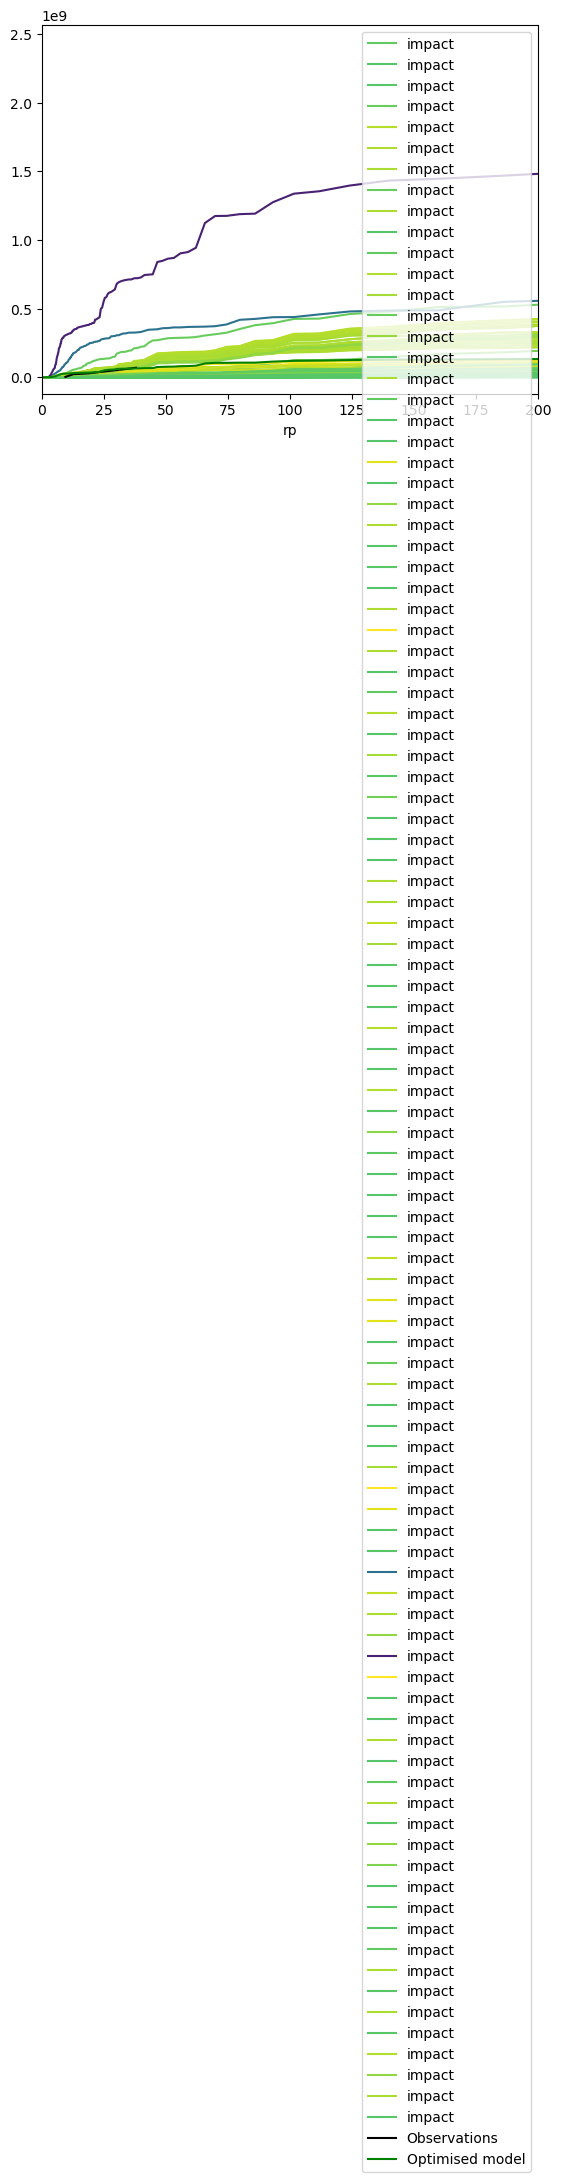

In [27]:
n_iters = len(saved_results)
samples = np.random.randint(0, n_iters, 100)

for c in countries:
    country = pycountry.countries.get(name=c).alpha_3
    fig, ax = plt.subplots()
    for i in samples:
        df = saved_results[i]
        cost = cost_function(obs[['country', 'impact', 'rp']], df[['country', 'impact', 'rp']])
        # print('these results')
        # print(df)
        # print('obs')
        # print(obs)
        df[df['country'] == country].plot(x='rp', y='impact', legend=False, color=cmap(norm(cost)), ax=ax)
        # break
    obs[obs['country'] == country].plot(x='rp', y='impact', label='Observations', color='black', ax=ax)
    optimal_df[optimal_df['country'] == country].plot(x='rp', y='impact', label='Optimised model', color='green', ax=ax)
    ax.set_xlim([0, 200])
    plt.show()

calibration_v1/TC/SI/TC_SI_a97fcdf8
calibration_v1/TC/SI/TC_SI_0e7435d2
calibration_v1/TC/SI/TC_SI_474c9e46
calibration_v1/TC/SI/TC_SI_e76ac251
calibration_v1/TC/SI/TC_SI_ec26a16b
calibration_v1/TC/SI/TC_SI_bc7b4524
calibration_v1/TC/SI/TC_SI_c2d8ac09
calibration_v1/TC/SI/TC_SI_1882e5a7
calibration_v1/TC/SI/TC_SI_f57bf675
calibration_v1/TC/SI/TC_SI_2e87bc0a
calibration_v1/TC/SI/TC_SI_8c628870
calibration_v1/TC/SI/TC_SI_93a1f983
calibration_v1/TC/SI/TC_SI_afd586d3
calibration_v1/TC/SI/TC_SI_92bdee45
calibration_v1/TC/SI/TC_SI_444373c4
calibration_v1/TC/SI/TC_SI_6d735ff8
calibration_v1/TC/SI/TC_SI_051acd64
calibration_v1/TC/SI/TC_SI_2a22d8d5
calibration_v1/TC/SI/TC_SI_5477b7d7
calibration_v1/TC/SI/TC_SI_18e1b062
calibration_v1/TC/SI/TC_SI_1a667f5a
calibration_v1/TC/SI/TC_SI_5b3c8101
({'scale': 0.9451488084309052, 'v_half': 98.6542704799425}, 335769256.57366097)
calibration_v1/TC/SI/TC_SI_206fe2bd
calibration_v1/TC/SI/TC_SI_49e560ef
calibration_v1/TC/SI/TC_SI_2b752c61
calibration_v1/TC/SI

KeyError: 'rp_x'

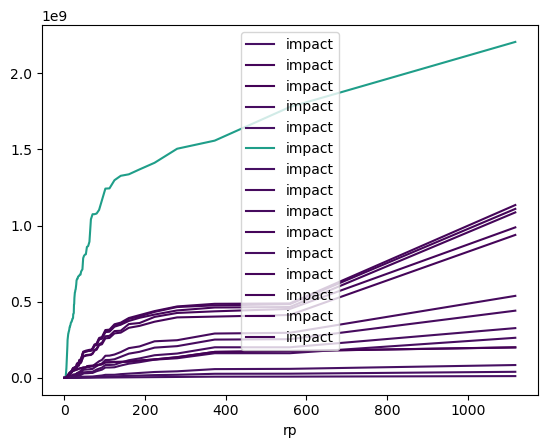

In [18]:
# Testing cost functions...
import matplotlib.cm as cm
from calibration.rp_errors import merge_outputs_and_obs
country = 'MOZ'
fig, ax = plt.subplots()

norm = plt.Normalize(min(cost_df['Cost Function']), max(cost_df['Cost Function']))
cmap = cm.get_cmap('viridis')  # Choose a colormap

for i in samples:
    try:
        params = parameter_df.iloc[i,].to_dict()
        cost = cost_df.iloc[i,].to_dict()['Cost Function']
        df = get_results_from_params(params)
        print((params, cost))
        rps = merge_outputs_and_obs(df, obs)
        colour = cmap(norm(cost))
        df[df['country'] == country].plot(x='rp', y='impact', label=None, color=colour, ax=ax)
    except FileNotFoundError:
        pass

rps[rps['country'] == country].plot(x='rp_x', y='obs', label='Observations', color='black', ax=ax)
plt.show()


# The optimised impact function

In [ ]:
from pipeline.direct import apply_sector_impf_set
from climada.entity import ImpfTropCyclone, ImpactFuncSet

impf_best_guesstimate = apply_sector_impf_set("tropical_cyclone", "economic_assets", countries[0], business_interruption=False, calibrated=False)
impf_best_guesstimate.name = 'Best guesstimate'

def get_impact_function_from_params(params):
    impf = ImpfTropCyclone.from_emanuel_usa(
                scale=params['scale'],
                v_thresh=25.8, # params['v_thresh'],
                v_half=params['v_half']
            )

impf_calibrated = get_impact_function_from_params(optimal_params)
impf_calibrated.name = "Optimal"

impf_set = ImpactFuncSet([impf_best_guesstimate, impf_calibrated])
impf_set.plot()

The CLIMADA analyses have a nice bit of functionality that lets you explore the range of impact functions and the hazards that went into them. They depend on CLIMADA-specific classes, but we can construct them with the data we've created in this notebook and module.

In [ ]:
from pipeline.direct import get_hazard, get_sector_exposure
from climada.hazard import Hazard
from climada.entity import Exposures
from climada.util.calibrate import Input, Output, BayesianOptimizerOutputEvaluator

haz = Hazard.concat([get_hazard("tropical_cyclone", c, "None", "historical") for c in countries_iso3alpha])
exp = Exposures.concat([get_sector_exposure('economic_assets', c) for c in countries_iso3alpha])

bo_input = Input(
    hazard = haz,
    exposure = exp,
    data = None,
    impact_func_creator = get_impact_function_from_params,
    impact_to_dataframe = None,
    cost_func = None,
    bounds = None,
    constraints = None
    # impact_calc_kwds: Mapping[str, Any] = field(
    #     default_factory=lambda: {"assign_centroids": False}
    # )
    # missing_data_value: float = np.nan
    # assign_centroids: InitVar[bool] = True
)

bo_output = Output(
    params = bayes_output.params,
    target = bayes_output.target,
)


evaluator = BayesianOptimizerOutputEvaluator(
    input = bo_input,
    output = bo_output,
    p_space = opt._space
)

In [ ]:
evaluator.plot_impf_variability()